In [231]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [232]:
df=pd.read_csv('Data/Source_Images/Test_Images/Annotations-export-test.csv')
print(df.head())

     image    xmin   ymin    xmax    ymax                            label
0  501.jpg  134.75  32.94  148.50   56.73                    safety_helmet
1  502.jpg   30.25   5.49   79.75   62.22  has safety_helmet and face_mask
2  502.jpg  200.75   5.49  250.25   67.71  has safety_helmet and face_mask
3  502.jpg  123.75  31.11  145.75   62.22  has safety_helmet and face_mask
4  503.jpg  101.75  58.56  132.00  100.65    no safety_helmet or face_mask


In [233]:
df1=pd.read_csv('Data/Source_Images/Test_Image_Detection_Results/Detection_Results.csv')
print(df1.head())

     image                                         image_path  xmin  ymin  \
0  523.jpg  /home/nirmal/Documents/Customindz/TrainYourOwn...   191    25   
1  523.jpg  /home/nirmal/Documents/Customindz/TrainYourOwn...     2    14   
2  523.jpg  /home/nirmal/Documents/Customindz/TrainYourOwn...   258    40   
3  523.jpg  /home/nirmal/Documents/Customindz/TrainYourOwn...   165    46   
4  523.jpg  /home/nirmal/Documents/Customindz/TrainYourOwn...    94    54   

   xmax  ymax  label  confidence  x_size  y_size  
0   242    84      1    0.608342     284     178  
1    49    74      0    0.620927     284     178  
2   283    84      0    0.698098     284     178  
3   200    81      0    0.785716     284     178  
4   151    95      0    0.824980     284     178  


In [234]:
dict={}
v=df1['image'].unique()
for idx in v:
    #print(idx)
    data = df[df['image']==idx]
    coord = data[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
    #print(coord, cf_score)
    dict.update({idx : coord})
gt_boxes=dict
#print(gt_boxes)

In [235]:
dict1={}
for idx in v:
    #print(idx)
    data = df1[df1['image']==idx]
    coord = data[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
    cf_score=data['confidence'].values.tolist()
    #print(coord, cf_score)
    dict1.update({idx : {'boxes':coord, 'scores':cf_score}})
pred_boxs=dict1
#print(pred_boxs)

In [236]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [237]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [238]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [239]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [254]:
def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
        pred_boxes_pruned = deepcopy(pred_bb)
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        print("Mode score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
               
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]# Recalculate image results for this image
            #print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr=0.5)# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            print(recalls,"Recall")
            print(recall_level,"Recall Level")
            print(args, "Args")
            print(prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

In [259]:
res = get_avg_precision_at_iou(gt_boxes, pred_boxs, iou_thr=0.5)

Mode score :  0.4017480611801148
Mode score :  0.4076143503189087
Mode score :  0.4085692465305328
Mode score :  0.4089195728302002
Mode score :  0.4155067205429077
Mode score :  0.4169817268848419
Mode score :  0.4174952208995819
Mode score :  0.4182489812374115
Mode score :  0.42124196887016296
Mode score :  0.4217710793018341
Mode score :  0.4219469726085663
Mode score :  0.4244961738586426
Mode score :  0.4258873462677002
Mode score :  0.4266423285007477
Mode score :  0.4275533854961395
Mode score :  0.434596449136734
Mode score :  0.4367900192737579
Mode score :  0.4370891451835632
Mode score :  0.4391454160213471
Mode score :  0.4403132200241089
Mode score :  0.4449244737625122
Mode score :  0.4454376399517059
Mode score :  0.4454648196697235
Mode score :  0.44551920890808105
Mode score :  0.4457839727401733
Mode score :  0.4478781819343567
Mode score :  0.448051780462265
Mode score :  0.4505766332149506
Mode score :  0.4520626962184906
Mode score :  0.4526448249816895
Mode score

[Text(0, 0.5, 'Precision'), Text(0.5, 0, 'Recall')]

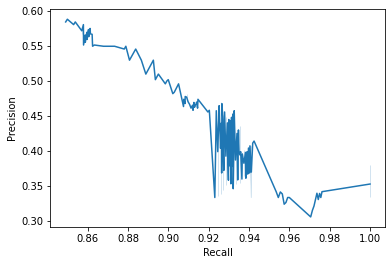

In [284]:
ax=sns.lineplot(res['precisions'],res['recalls'])
ax.set(xlabel='Recall', ylabel='Precision')

In [285]:
mAP = res['avg_prec']
print(mAP)

0.6363636363636364
